## HAN

In [1]:
from sklearn.datasets import fetch_20newsgroups

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using Theano backend.


In [2]:
features_all = fetch_20newsgroups(subset='all').data
features_all[:2]

["From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>\nSubject: Pens fans reactions\nOrganization: Post Office, Carnegie Mellon, Pittsburgh, PA\nLines: 12\nNNTP-Posting-Host: po4.andrew.cmu.edu\n\n\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n",
 'From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)\nSubject: Which h

In [3]:
targets_all = fetch_20newsgroups(subset='all').target
targets_all

array([10,  3, 17, ...,  3,  1,  7])

In [4]:
# 清除\, ", '
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [6]:
from nltk import tokenize
import re
import os

reviews = []

for text in features_all:

    text = clean_str(text.encode('ascii','ignore').decode("utf-8"))
    
    sentences = tokenize.sent_tokenize(text) # 句子字符串组成的列表

    reviews.append(sentences)

In [7]:
len(reviews)

18846

In [8]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

os.environ['KERAS_BACKEND'] = 'theano'

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(features_all)

In [9]:
import numpy as np

max_sents =15
max_sent_length = 100

data = np.zeros((len(reviews), max_sents, max_sent_length), dtype='int32')
data.shape

(18846, 15, 100)

In [10]:
word_index = tokenizer.word_index
len(word_index)

179209

In [11]:
for i, doc in enumerate(reviews):
    # doc是句子列表，首先对句子进行分词，形成2维列表
    doc = tokenizer.texts_to_sequences(doc) # 文档2维列表：每个元素为1维句子列表

    doc = pad_sequences(doc, maxlen=100) # 限定句子长度为100，不足的在前方补0
    
    # 限定文档长度为15，使 doc.shape = (15, 100)
    if len(doc) >= 15:
        doc = doc[:15]
    else:
        doc = np.row_stack( ( np.zeros((15-len(doc), 100), dtype='int32'), doc ) ) # 不足的在矩阵上方补0

    data[i] = doc

In [12]:
data[20].shape

(15, 100)

In [13]:
# 和原始数据集大小保持基本一致
x_train = data[:9051]
x_val = data[9051:11314]
x_test = data[11314:]
print(x_train.shape, x_val.shape, x_test.shape)

(9051, 15, 100) (2263, 15, 100) (7532, 15, 100)


In [14]:
targets = to_categorical(targets_all).astype(int)
targets.shape

(18846, 20)

In [15]:
# 和原始数据集大小保持基本一致
y_train = targets[:9051]
y_val = targets[9051:11314]
y_test = targets[11314:]
print(y_train.shape, y_val.shape, y_test.shape)

(9051, 20) (2263, 20) (7532, 20)


In [16]:
y_train.sum(axis=0)

array([375, 471, 457, 470, 459, 508, 466, 454, 509, 474, 479, 458, 508,
       463, 474, 485, 434, 439, 363, 305])

In [17]:
y_val.sum(axis=0)

array([103, 111, 130, 114, 115, 108, 124, 117, 125, 120, 123, 128, 110,
       117, 111, 110, 113, 114,  88,  82])

In [18]:
y_test.sum(axis=0)

array([321, 391, 398, 398, 389, 372, 385, 419, 362, 400, 397, 405, 366,
       410, 402, 402, 363, 387, 324, 241])

In [19]:
# 从GloVe文件中解析出每个词和它所对应的词向量，并用字典的方式存储
embeddings_index = {}
with open('glove.6B.100d.txt') as tf:
    lines = tf.readlines()
    for line in lines:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(len(embeddings_index))

400000


In [20]:
# 构建词向量矩阵, 没有的单词的词向量均为0
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, idx in word_index.items():
    embed_vector = embeddings_index.get(word)
    if embed_vector is not None:
        embedding_matrix[idx] = embed_vector

In [21]:
from keras.layers import Embedding

# 词向量加载到embedding层中，trainable=False 使得这个编码层不可再训练
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_sent_length,
                            trainable=True)

In [22]:
# 定义 Attention 层
from keras import backend as K
from keras import initializers
from keras.engine.topology import Layer
import numpy as np
import tensorflow as tf

class AttLayer(Layer):
    def __init__(self, **kwargs):
        self.init = initializers.get('normal')
        super(AttLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        #self.W = self.init((input_shape[-1],))
        #self.trainable_weights = [self.W]
        #super(AttLayer, self).build(input_shape)
        
        self.W = self.add_weight(name='kernel', shape=(input_shape[-1],), initializer='normal', trainable=True)
        super(AttLayer, self).build(input_shape)  
        
    def call(self, x, mask=None):
        # eij = K.squeeze(K.dot(x, K.expand_dims(self.W)), axis=-1)
        eij = K.tanh(K.squeeze(K.dot(x, K.expand_dims(self.W)), axis=-1))
        
        ai = K.exp(eij)
        weights = ai / K.sum(ai, axis=1).dimshuffle(0, 'x')
        # ai_sum = tf.reshape(K.sum(ai, axis=1), shape=[-1, 1])
        # weights = ai / ai_sum
        
        weighted_input = x * weights.dimshuffle(0, 1, 'x') # 变成tensorflwo这里会报错，修改成reshape仍会报错
        # weights = tf.reshape(weights, shape=[weights[0], weights[1], 1])
        # weighted_input = x * weights
        return weighted_input.sum(axis=1)
        
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [23]:
from keras.layers import Input, Bidirectional, GRU, TimeDistributed, Dense
from keras.models import Model


sentence_input = Input(shape=(max_sent_length,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
l_dense = TimeDistributed(Dense(200))(l_lstm)
l_att = AttLayer()(l_dense)
sentEncoder = Model(sentence_input, l_att)

review_input = Input(shape=(max_sents, max_sent_length), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)
l_lstm_sent = Bidirectional(GRU(100, return_sequences=True))(review_encoder)
l_dense_sent = TimeDistributed(Dense(200))(l_lstm_sent)
l_att_sent = AttLayer()(l_dense_sent)
preds = Dense(20, activation='softmax')(l_att_sent)
model = Model(review_input, preds)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15, 100)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 200)           18082000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 15, 200)           180600    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 200)           40200     
_________________________________________________________________
att_layer_2 (AttLayer)       (None, 200)               200       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                4020      
Total params: 18,307,020
Trainable params: 18,307,020
Non-trainable params: 0
________________________________________________________________

In [24]:
history_han = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15, batch_size=128)

Train on 9051 samples, validate on 2263 samples
Epoch 1/15
9051/9051 [==============================] - 681s 75ms/step - loss: 2.3964 - acc: 0.2095 - val_loss: 1.7390 - val_acc: 0.3999
Epoch 2/15
9051/9051 [==============================] - 672s 74ms/step - loss: 1.5175 - acc: 0.4576 - val_loss: 1.2636 - val_acc: 0.5369
Epoch 3/15
9051/9051 [==============================] - 672s 74ms/step - loss: 1.0736 - acc: 0.6165 - val_loss: 0.9548 - val_acc: 0.6580
Epoch 4/15
9051/9051 [==============================] - 686s 76ms/step - loss: 0.7739 - acc: 0.7363 - val_loss: 0.7670 - val_acc: 0.7428
Epoch 5/15
9051/9051 [==============================] - 723s 80ms/step - loss: 0.5512 - acc: 0.8139 - val_loss: 0.7636 - val_acc: 0.7406
Epoch 6/15
9051/9051 [==============================] - 711s 79ms/step - loss: 0.4125 - acc: 0.8663 - val_loss: 0.5912 - val_acc: 0.8184
Epoch 7/15
9051/9051 [==============================] - 705s 78ms/step - loss: 0.2997 - acc: 0.9039 - val_loss: 0.6118 - val_acc: 

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


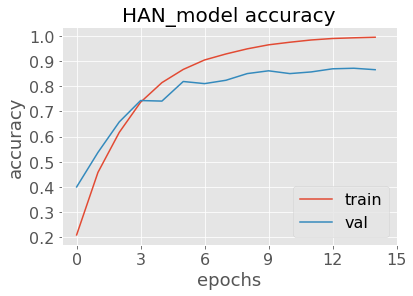

In [26]:
# 绘制模型的训练和验证曲线
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签

plt.plot(history_han.history['acc'])
plt.plot(history_han.history['val_acc'])

plt.legend(['train', 'val'], loc='lower right', fontsize=16)

plt.title('HAN_model accuracy', fontsize=20)
plt.xlabel('epochs', fontsize=18)
plt.ylabel('accuracy', fontsize=18)

plt.xticks(range(0, 16, 3), fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [27]:
# 模型测试 评估
score, acc = model.evaluate(x_test, y_test, batch_size=128)
print('Test score:', score)
print('Test accuracy:', acc)

7532/7532 [==============================] - 144s 19ms/step
Test score: 0.813855219349
Test accuracy: 0.855815188434


In [29]:
y_preds = model.predict(x_test, batch_size=128)

In [30]:
y_preds.shape

(7532, 20)

In [31]:
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE()
y_tsne = tsne.fit_transform(y_preds)

In [32]:
y_test_index = np.argmax(y_test, axis=1)
y_test_index

array([ 2,  4, 16, ...,  3,  1,  7])

In [33]:
print(y_test.shape, y_test_index.shape)

(7532, 20) (7532,)


In [34]:
def plot_scatter(x, labels, title):
    plt.figure(figsize=(13, 10))
    plt.title(title)
    plt.scatter(x[:,0], x[:,1], c = labels, s = 5)
    plt.colorbar(ticks=range(20))
    plt.clim(-0.5, 19.5)
    plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


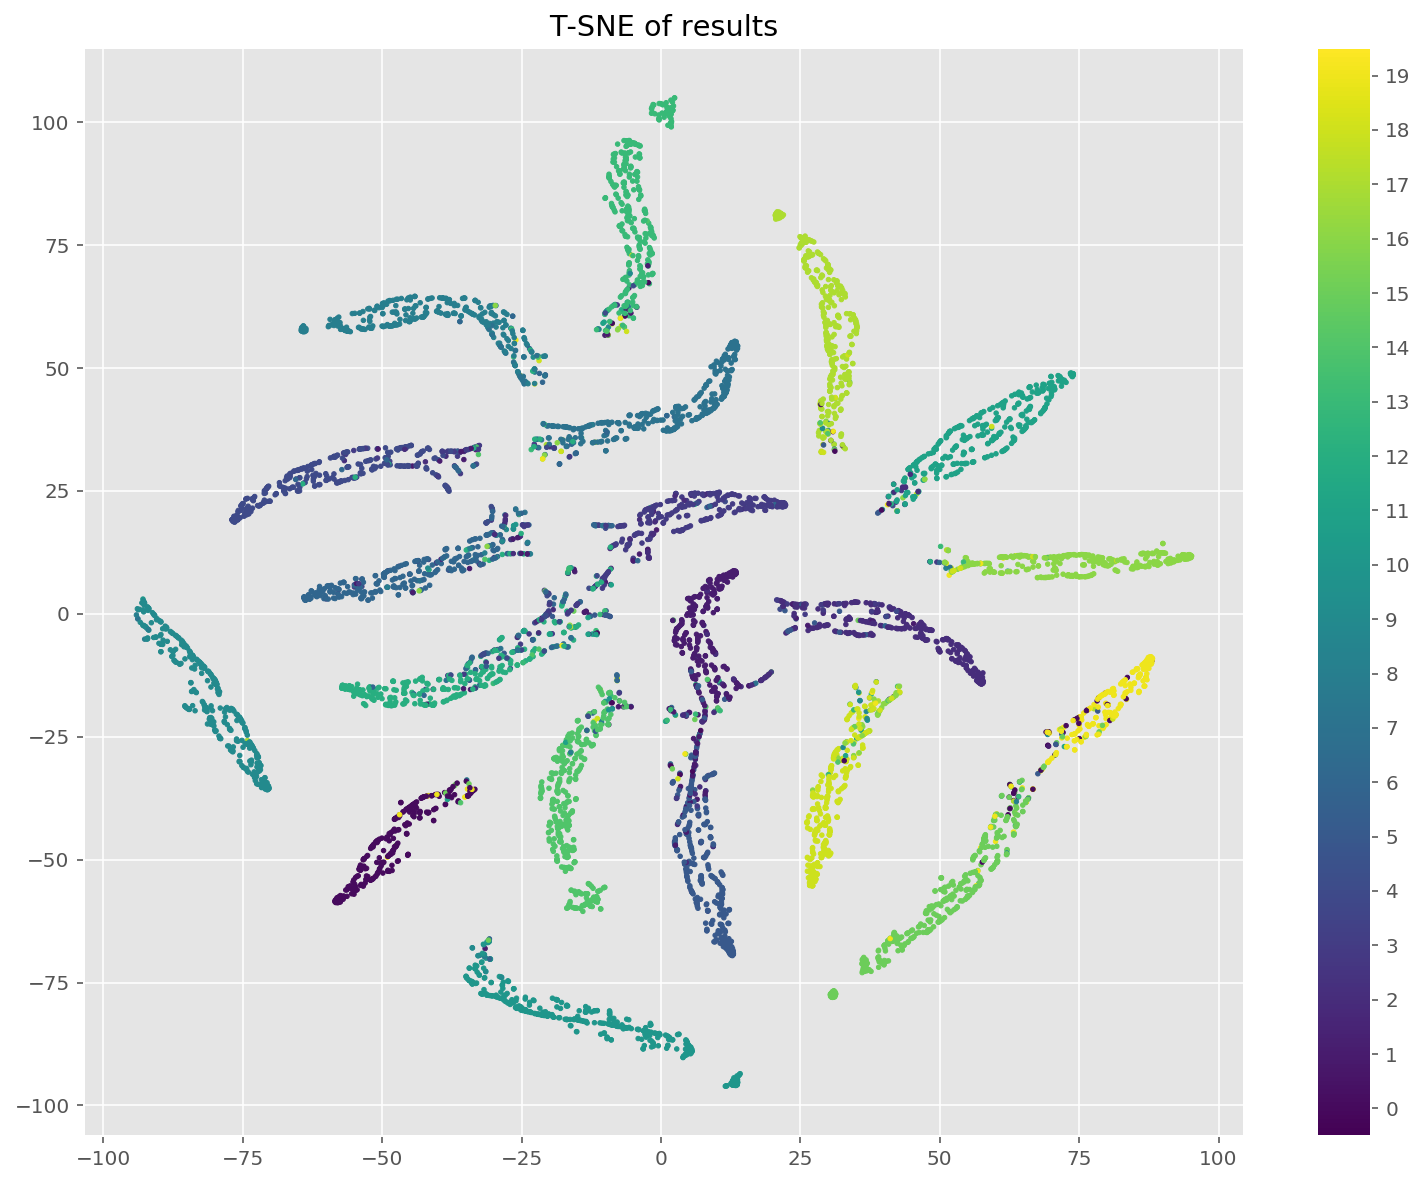

In [35]:
plot_scatter(y_tsne, y_test_index, 'T-SNE of results')

In [28]:
model.save('han.h5')

In [ ]:
# from keras.models import load_model

# model = load_model('han.h5')